### Portland General Electric Demand Model and Temperature Analysis for 2021

This is a quick model to estimate PGE's demand given temperature, and time of day. 

This is a quick analysis to identify if there is a correlation between Portland General Electric (PGE) hourly demand, demand forecast, and daytime mean temperature. 

This notebook will also serve as a guide for creating API calls on the EIA website. 

Background: PGE is a major public utility which distributes electricty to 44% of Oregon's inhabitants (including customers in Multnomah county). 

The year 2021 was selected as Oregon experienced [record temperatures](https://www.opb.org/article/2022/02/10/oregons-2021-heat-dome-notches-another-record/). Some parts of oregon reached 119F. 

The data for this analysis comes from the U.S. Energy Information Administration (https://www.eia.gov/opendata/). Data is made available via their public API. 

There are obviously many more things that affect demand, including: 
- Calendar variations (holidays, days of week, etc.) 
- Price of electricity 
- Economic activity 
- Price of natural gas / other fuels 
- Industry trends (more EVs, more solar panels, more heatpumps, etc.) 
- Population changes 

Each input variable can affect the output in different ways. 


# ASSUMPTIONS AND IMPROVEMENTS:
1. Right now, temperature is represented as temperature in Portland, OR. It would be better to use a mean weighted temperature for the areas that PGE serves. More customers in an area would get a higher temperature weight. 
However, most of Oregon's population in concentrated in the Portland metro area (2.5M people of Oregon's 4.2M population). Therefore, the temperature in Portland is selected as a representative temperature. 

2. For this analysis, I assumed that the temperature data from https://open-meteo.com/ is reliable. However, I didn't cross check it against any other historic weather APIs. I'd like to look into that data source more. 

3. Right now, only data from 2021 is used to build the model. Other years could be brouht in to make the model more robust. 



#### FURTHER INVESTIGATION IDEAS: 
1. Would be interesting to see how R^2 changes over time... assuming their modeling capabilities get better over time, plot R^2 as a function of time per month... although the data only goes back to 2015. 
2. Create a naive model and see how my forecast compares to it. 

In [748]:
import requests
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from dotenv import dotenv_values #reads key-value pairs from a .env file and can set them as environment variables

In [517]:
# This loads the shell environment into the jupyter notebook environment
# So it is possible to get environmental variables that are in the .env file in the shell into this environment 
%load_ext dotenv
%dotenv -o -v

# Get the EIA_API_KEY from the environment 
EIA_API_KEY = os.environ.get("EIA_API_KEY")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### EIA API Call 
Below, the API call is made to get PGE's hourly demand and demand forecast data. 
#### NOTE on Limits, and Pagination 
"EIA's API limits its data returns to the first 5,000 rows responsive to the request."
[source](https://www.eia.gov/opendata/documentation.php)

Therefore, 12 calls will be made; one for each month. Then, the 12 calls will be concatenated into one pandas dataframe. 

In [765]:
# List of tuples consisting of (month number, number of days in month)... quick, and not cute. But it works
months = [('01','31'),('02','28'),('03','31'),('04','30'),('05','31'),('06','30'),
          ('07','31'),('08','31'),('09','30'),('10','31'),('11','30'),('12','31')]
# empty dataframe to concatentate the data into 
dfs = []

for month in months: 
    eia_url = ('https://api.eia.gov/v2/electricity/rto/region-data/data/?' +
          f'api_key={EIA_API_KEY}&' +
          'frequency=hourly&' +
          'data[0]=value&' +
          'facets[respondent][]=PGE&' +
          f'start=2021-{month[0]}-01T00&end=2021-{month[0]}-{month[1]}T23&' +
          'sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000')
    response = requests.get(eia_url)
    eia_json = response.json()
    month_dataframe = pd.DataFrame.from_dict(eia_json['response']['data'])
    dfs.append(month_dataframe)


Concatenate the monthly data into one dataframe for 2021 

In [766]:
pge_all_data = pd.concat(dfs)

In [767]:
# There is a single null value that is dropped 
pge_all_data.dropna(inplace=True)

Clean the data a bit to get all of the data types into their expected format:  
- `period` needs to be updated from `object` to `datetime64`  
- `respondent`, `respondent-name`, `type`, `type-name`, and `value-units` can remain as `object`  
- `value` can remain as `float64`

In [814]:
pge_all_data['period']= pd.to_datetime(pge_all_data['period'])
# Also do a sort of the data to ensure it is sorted ascending by time 
pge_all_data.sort_values(by='period', inplace=True)
# Create a new column to represent hour of day, for analysis later 
pge_all_data['hour'] = pge_all_data['period'].dt.hour
pge_all_data['month'] = pge_all_data['period'].dt.month

In [816]:
# Preview the data
pge_all_data.head(8)

,period,respondent,respondent-name,type,type-name,value,value-units,hour,month
2975,2021-01-01 00:00:00,PGE,Portland General Electric Company,TI,Total interchange,-2153.0,megawatthours,0,1
2974,2021-01-01 00:00:00,PGE,Portland General Electric Company,NG,Net generation,544.0,megawatthours,0,1
2973,2021-01-01 00:00:00,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,2800.0,megawatthours,0,1
2972,2021-01-01 00:00:00,PGE,Portland General Electric Company,D,Demand,2697.0,megawatthours,0,1
2971,2021-01-01 01:00:00,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,2918.0,megawatthours,1,1
2970,2021-01-01 01:00:00,PGE,Portland General Electric Company,NG,Net generation,659.0,megawatthours,1,1
2968,2021-01-01 01:00:00,PGE,Portland General Electric Company,D,Demand,2802.0,megawatthours,1,1
2969,2021-01-01 01:00:00,PGE,Portland General Electric Company,TI,Total interchange,-2143.0,megawatthours,1,1


## Get historic weather data for Portland, OR 

The weather data is sourced using this api: https://open-meteo.com/
Time is in **Pacific Time**. 
Temperature is the air temperature at 2 meters above ground. 
Data is for Portland, OR 

In [648]:
weather_url = ('https://archive-api.open-meteo.com/v1/archive?' +
               'latitude=45.52&longitude=-122.68&' +
               'start_date=2021-01-01&end_date=2021-12-31&' +
               'hourly=temperature_2m&' +
               'timezone=America%2FLos_Angeles&' +
               'temperature_unit=fahrenheit&windspeed_unit=ms&precipitation_unit=inch')

response = requests.get(weather_url)

In [649]:
weather_data = response.json()
hourly_temp = pd.DataFrame.from_dict(weather_data['hourly'])
hourly_temp['time']= pd.to_datetime(hourly_temp['time'])
hourly_temp.rename(columns={"temperature_2m": "temp"}, inplace=True)
hourly_temp.head(5)

,time,temp
0,2021-01-01 00:00:00,45.3
1,2021-01-01 01:00:00,45.5
2,2021-01-01 02:00:00,45.4
3,2021-01-01 03:00:00,45.4
4,2021-01-01 04:00:00,45.5


## Join energy and temperature data

In [823]:
energy_and_temp = pge_all_data.merge(hourly_temp, how='inner', left_on='period', right_on='time')
energy_and_temp.drop(columns=['respondent-name'], inplace=True)

## Filter data by type-name (demand, generation, forecast)
Now, separate out the different data types in the dataframe 

In [825]:
demand = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Demand')].copy()
demand.rename(columns={"value": "demand"}, inplace=True)
# generation = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Net generation')] 
forecast = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Day-ahead demand forecast')].copy()
forecast.rename(columns={"value": "forecast"}, inplace=True)

## Plot of energy usage and temperature over time

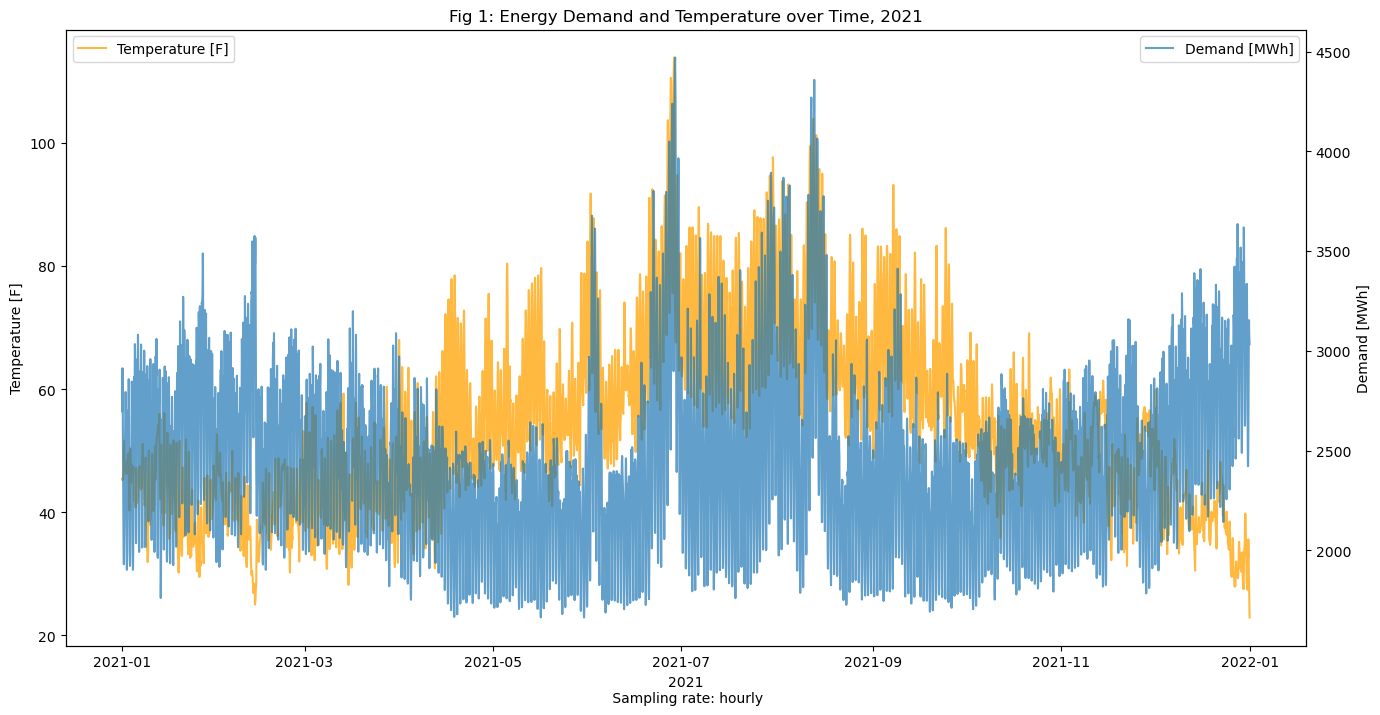

In [826]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()
plt.title("Fig 1: Energy Demand and Temperature over Time, 2021")

ax1.plot(demand['time'], demand['temp'], label='Temperature [F]', color="#ffb940") # orange color
ax2.plot(demand['time'], demand['demand'], label='Demand [MWh]', alpha=0.7)

ax1.set_xlabel('2021\n Sampling rate: hourly')
ax1.set_ylabel('Temperature [F]')
ax2.set_ylabel('Demand [MWh]')

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

### Autocorrelation 

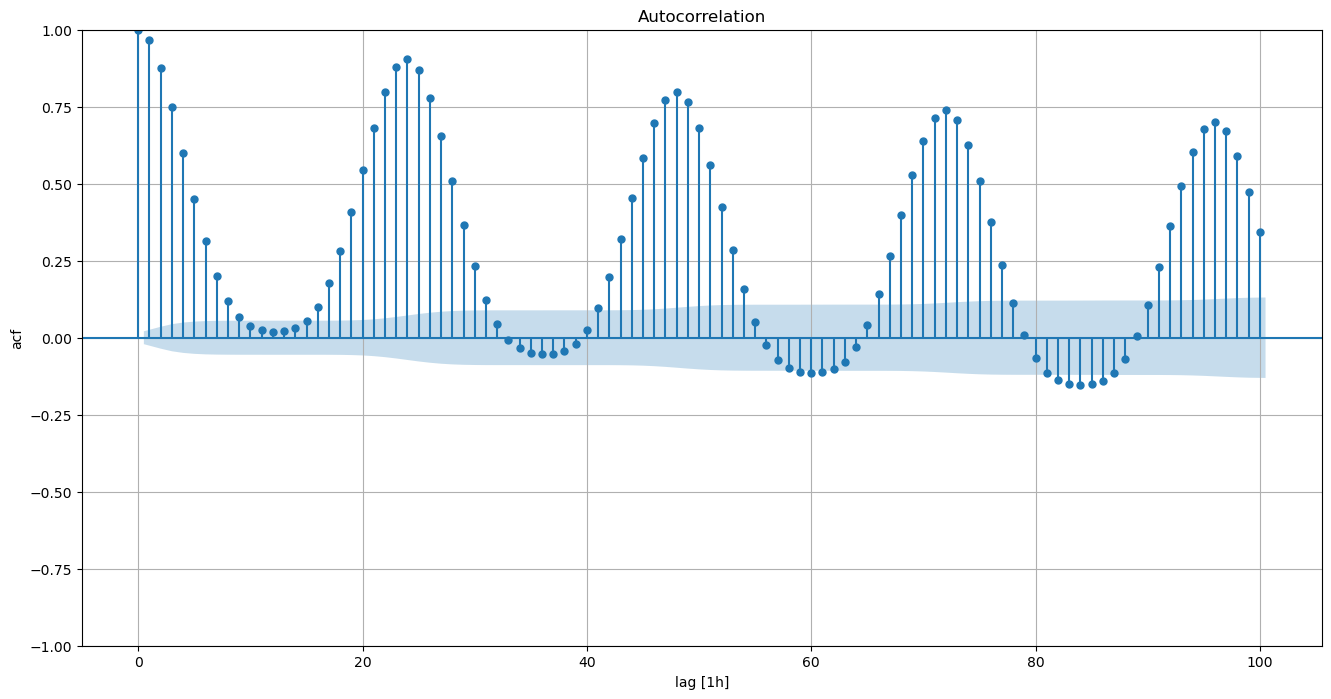

In [902]:
fig, ax = plt.subplots(figsize=(16,8))
sm.graphics.tsa.plot_acf(demand.demand, ax=ax, lags=100)
ax.set(ylim=(-1,1), xlabel='lag [1h]', ylabel='acf')
plt.grid()

Plot shows that demand from previous day is a good indicator of demand for next day (lag of 24 hours). 

### Time Series Decomposition for Energy Demand 

[Text(0, 0.5, 'Demand')]

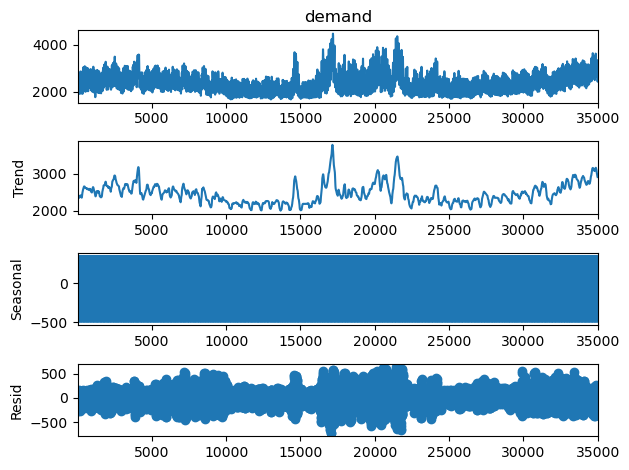

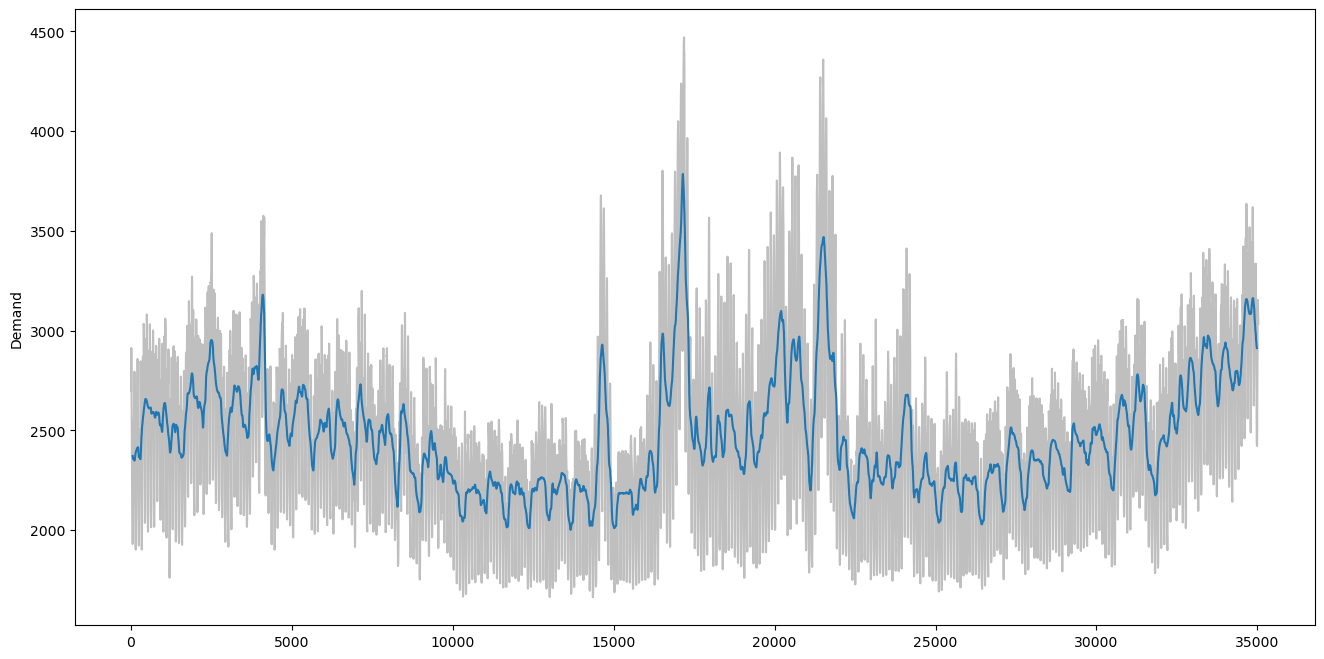

In [904]:
result = seasonal_decompose(demand['demand'], period=24, model='additive')
result.plot(result)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(demand.demand, color='.5', alpha=.5)
ax.plot(result.trend)
ax.set(ylabel='Demand')



## PGE's Demand Forecasing 
Below, compare PGE's demand to their demand forecast for the next day.


NOTE: I believe the `Day-ahead demand forecast` values have already been appropriately shifted to be in the same row as the date they supposedly forecast for. 
I originally assumed they would need to be shifted to a day later. After manually shifting it, the R^2 value dropped from 0.95 to 0.74. 
Of course, they *may* need to be shifted, but I would be surprised if their R^2 value for forecasting was that low. 

In [827]:
demand_forecast = forecast.merge(demand, how='inner', left_on='time', right_on='time')

Getting the fit for PGE's demand vs forecast.  
Doing a simple linear regression of form `y=mx+B`

In [671]:
# demand array must be 2D, reshape() makes this nympy array 2D
# reshape is a numpy operator, so use .values to turn the pd series into a np array 
demand_x = demand_forecast['demand'].values.reshape(-1,1)
forecast_y = demand_forecast['forecast'].values.reshape(-1,1)
model = LinearRegression().fit(demand_x, forecast_y)
r_sq = model.score(demand_x, forecast_y)
print(r_sq, model.intercept_, model.coef_)

0.95993211409628 [15.4595371] [[0.99893615]]


The R^2 value for the fit is 0.96  
The y-intercept (B) is 15.48  
The slope (x) is ~1.00 (as expected)

Let's plot the data on a scatter plot with the linear fit 

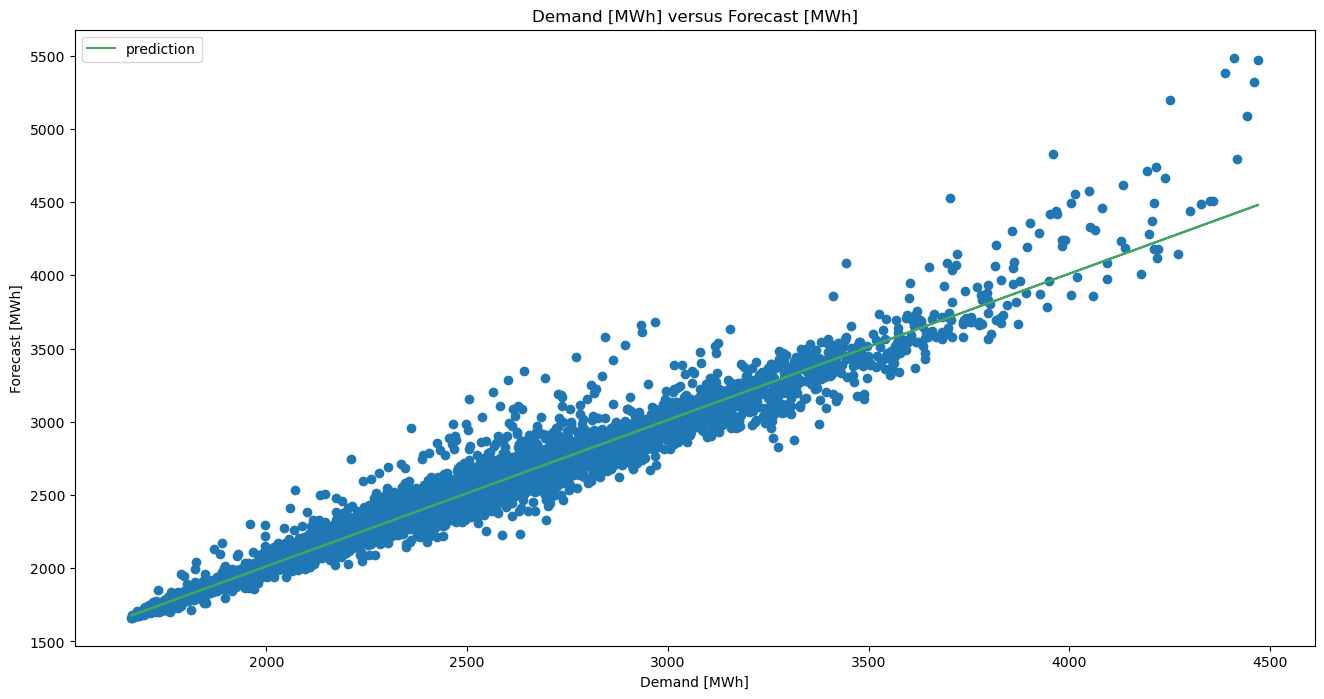

In [682]:
plt.figure(figsize=(16,8))
plt.title('Demand [MWh] versus Forecast [MWh]')
plt.xlabel("Demand [MWh]")
plt.ylabel("Forecast [MWh]")
plt.scatter(demand_x, forecast_y)
plt.plot(demand_x, model.coef_ * demand_x + model.intercept_, label='prediction', color="#42a65e")

plt.legend()
plt.show()

Note: Prediction is further from actual demand on the highest energy usage days.

0.4154875185067899 [2723.46043274] [[ 1.48028444e+02 -5.51005233e+01  4.34333267e+00 -9.76189643e-02]]


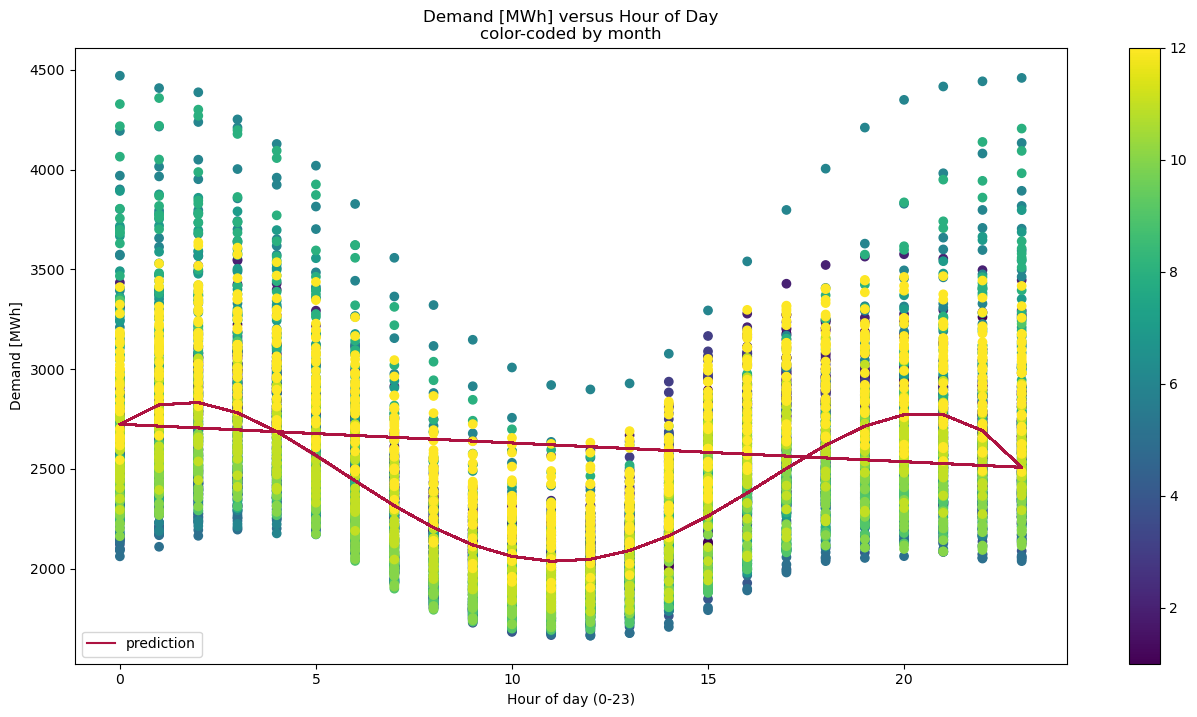

In [750]:
plt.figure(figsize=(16,8))
plt.scatter(demand['hour'], demand['demand'], c=demand['month'])
plt.title('Demand [MWh] versus Hour of Day\ncolor-coded by month')
plt.xlabel("Hour of day (0-23)")
plt.ylabel("Demand [MWh]")
plt.colorbar()
# GET THIS TO FILL WITH COLOR BY SEASON INSTEAD, AND MAKE DISCRETE COLOR STEPS, AND LABEL THE COLORS! 

hour_x = demand['hour'].values.reshape(-1,1)
demand_y = demand['demand'].values.reshape(-1,1)

transformer = PolynomialFeatures(degree=4, include_bias=False)
x_ = PolynomialFeatures(degree=4, include_bias=False).fit_transform(hour_x)
model = LinearRegression().fit(x_, demand_y)
r_sq = model.score(x_, demand_y)
print(r_sq, model.intercept_, model.coef_)
# 0.10452257757450756 [8864.69191734] [[-3.75295070e+02  8.04731524e+00 -7.60643712e-02  2.69105180e-04]]

plt.plot(hour_x, (model.coef_[0][0] * hour_x    + 
                  model.coef_[0][1] * hour_x**2 + 
                  model.coef_[0][2] * hour_x**3 + 
                  model.coef_[0][3] * hour_x**4 + 
                  model.intercept_), label='prediction', color="#ad1341")


plt.legend()
plt.show()


In [858]:
df = demand.copy()
df.set_index('hour', inplace=True)


**GROUP BY MONTH, THEN TAKE AVERAGE PER MONTH, AND PLOT THAT PER HOUR** 

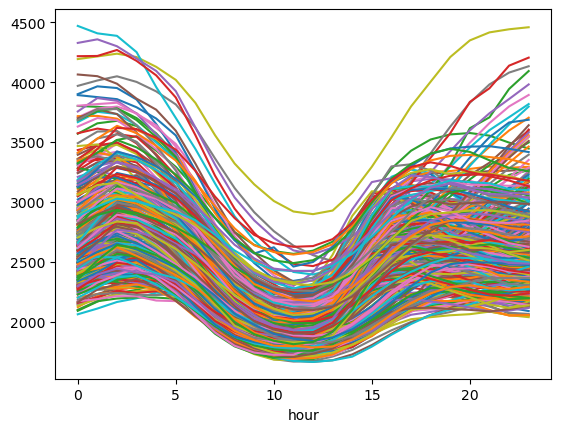

In [868]:
df.groupby(['month', df.time.dt.date])['demand'].plot()
plt.show()

Daily trends show high energy consumption in morning and evening. 

Morning due to need for heating, evening due to need for cooling and lights 

In [739]:
demand['model_prediction'] = (model.coef_[0][0] * demand['hour'] + 
                              model.coef_[0][1] * demand['hour']**2 + 
                              model.coef_[0][2] * demand['hour']**3 + 
                              model.coef_[0][3] * demand['hour']**4 + 
                              model.intercept_)

In [741]:
demand['residual'] = demand['demand'] - demand['model_prediction']

<AxesSubplot: xlabel='temp', ylabel='residual'>

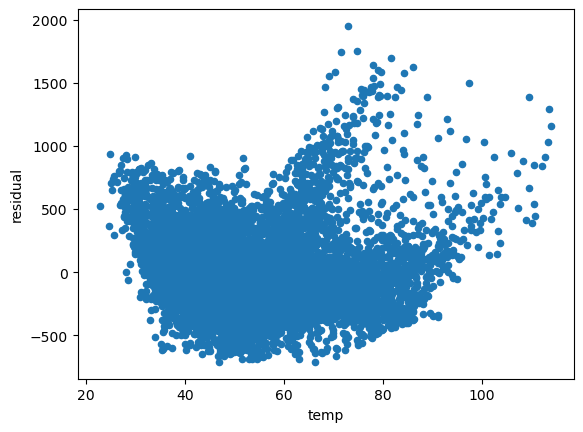

In [745]:
demand.plot.scatter(x='temp', y='residual')

## Creating a Model
There are a few obvious variables from looking at Fig 1 that should be investigated: 
- temperature
- week in the year (to account for seasonal fluctuations)
- time of day 
- day of week 
- season? 

It is clear that when temperatures are very high, or very low, energy demand increases due to need for heat or AC. 
When temperatures are moderate (spring and fall), energy demand falls, as likely many people do not run heat and AC as much. 

Temperature and demand are **not** homoscedastic -- the variance of the data is NOT the same over the time range. 

In [720]:
hour_x = demand['hour'].values.reshape(-1,1)
demand_y = demand['demand'].values.reshape(-1,1)

transformer = PolynomialFeatures(degree=4, include_bias=False)
x_ = PolynomialFeatures(degree=4, include_bias=False).fit_transform(temp_x)
model = LinearRegression().fit(x_, demand_y)
r_sq = model.score(x_, demand_y)
print(r_sq, model.intercept_, model.coef_)

0.10452257757450756 [8864.69191734] [[-3.75295070e+02  8.04731524e+00 -7.60643712e-02  2.69105180e-04]]


**3D plot showing temperature, demand, and hour of day**

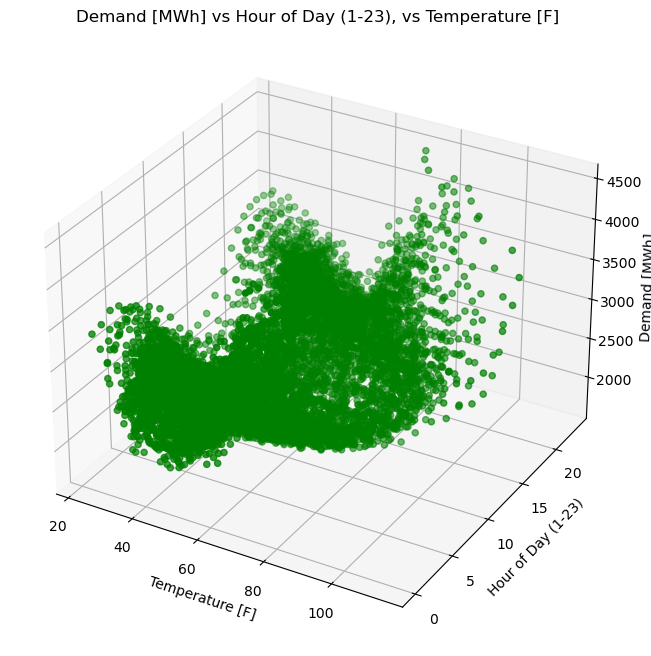

In [707]:
plt.figure(figsize=(16,8))
# Creating dataset
z = demand['demand'].values
x = demand['temp'].values
y = demand['hour'].values
 
# Creating figure
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color='g')
plt.title("Demand [MWh] vs Hour of Day (1-23), vs Temperature [F]")
ax.set_xlabel('Temperature [F]')
ax.set_ylabel('Hour of Day (1-23)')
ax.set_zlabel('Demand [MWh]')

plt.show()

## Plot of temperature versus demand

Appears parabolic. To complete model, may also want to add a time of day variable.

Fit a model of form y = ax^2 + bx + c

In [709]:
temp_x = demand['temp'].values.reshape(-1,1)
demand_y = demand['demand'].values.reshape(-1,1)

transformer = PolynomialFeatures(degree=2, include_bias=False)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(temp_x)
model = LinearRegression().fit(x_, demand_y)

In [710]:
r_sq = model.score(x_, demand_y)
print(r_sq, model.intercept_, model.coef_)

0.08918886160970052 [4019.95573635] [[-51.76910064   0.3971598 ]]


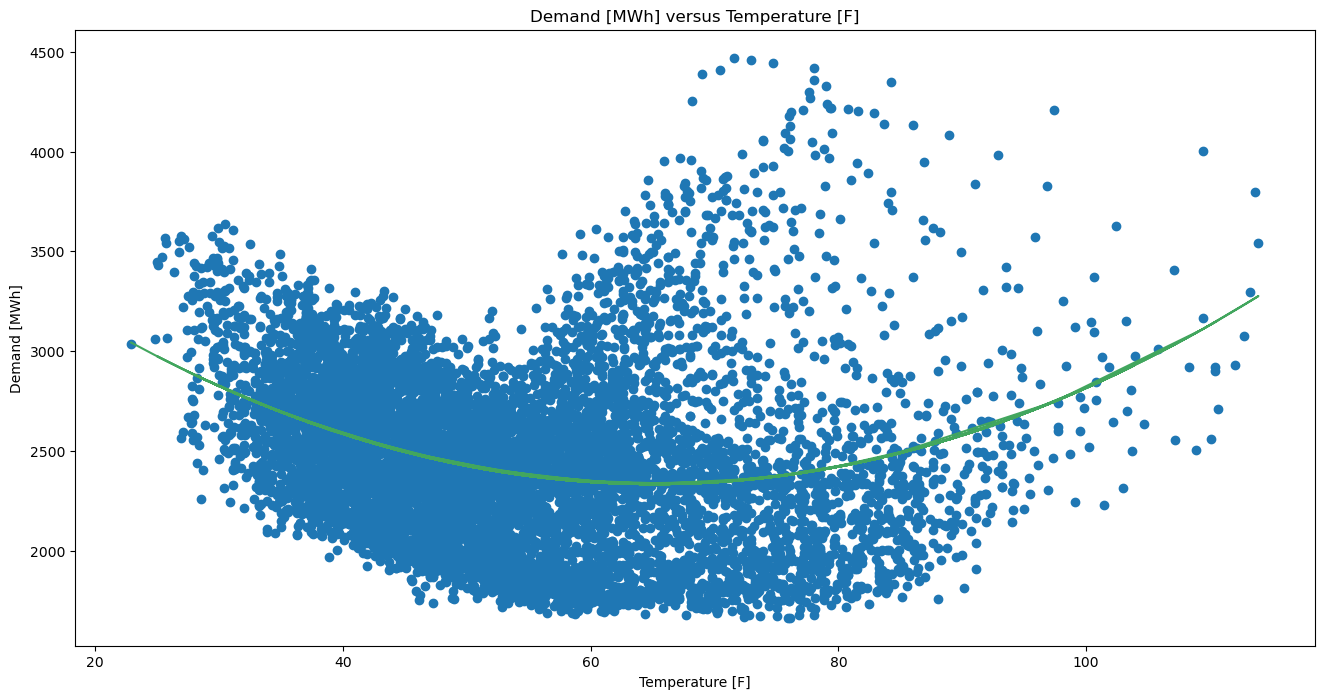

In [711]:
plt.figure(figsize=(16,8))
plt.title('Demand [MWh] versus Temperature [F]')
plt.xlabel("Temperature [F]")
plt.ylabel("Demand [MWh]")
plt.scatter(temp_x, demand_y)
# print(model.coef_[0][1])
plt.plot(temp_x, (model.coef_[0][0] * temp_x + model.coef_[0][1]* temp_x**2 + model.intercept_), label='prediction', color="#42a65e")

plt.show()


Look at residuals from the model: 